In [46]:
# ## 1. Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

In [47]:
# ## 2. Data Loading and Cleaning
try:
    df = pd.read_csv("/content/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-Telco-Customer-Churn.csv' not found. Please check the file path.")
    df = pd.DataFrame()

if not df.empty:
    # 'TotalCharges' 컬럼의 공백을 NaN으로 변환 후 숫자형으로 변경
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # TotalCharges 결측치는 tenure가 0인 고객이므로, MonthlyCharges 값으로 채우거나 0으로 채울 수 있음. 여기서는 0으로 처리.
    df['TotalCharges'].fillna(0, inplace=True)

    # customerID는 예측에 불필요하므로 제거
    df = df.drop("customerID", axis=1)

    # 타겟 변수 'Churn'을 숫자형으로 변환
    df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

    print("\nData after cleaning:")
    df.info()

Dataset loaded successfully.

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   obje

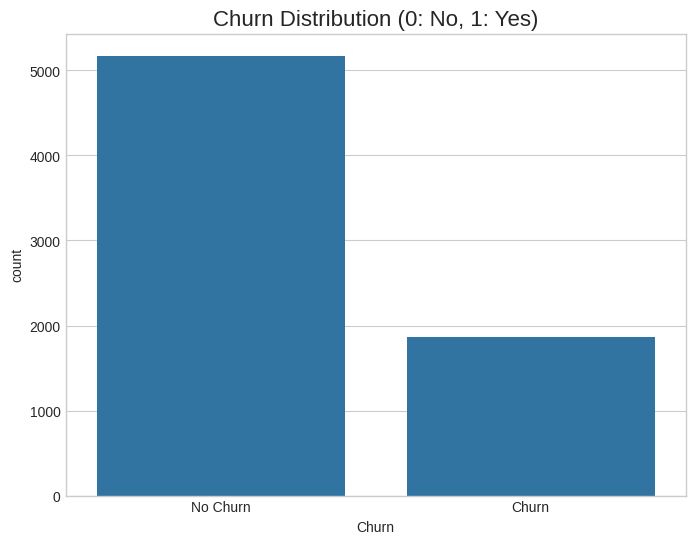

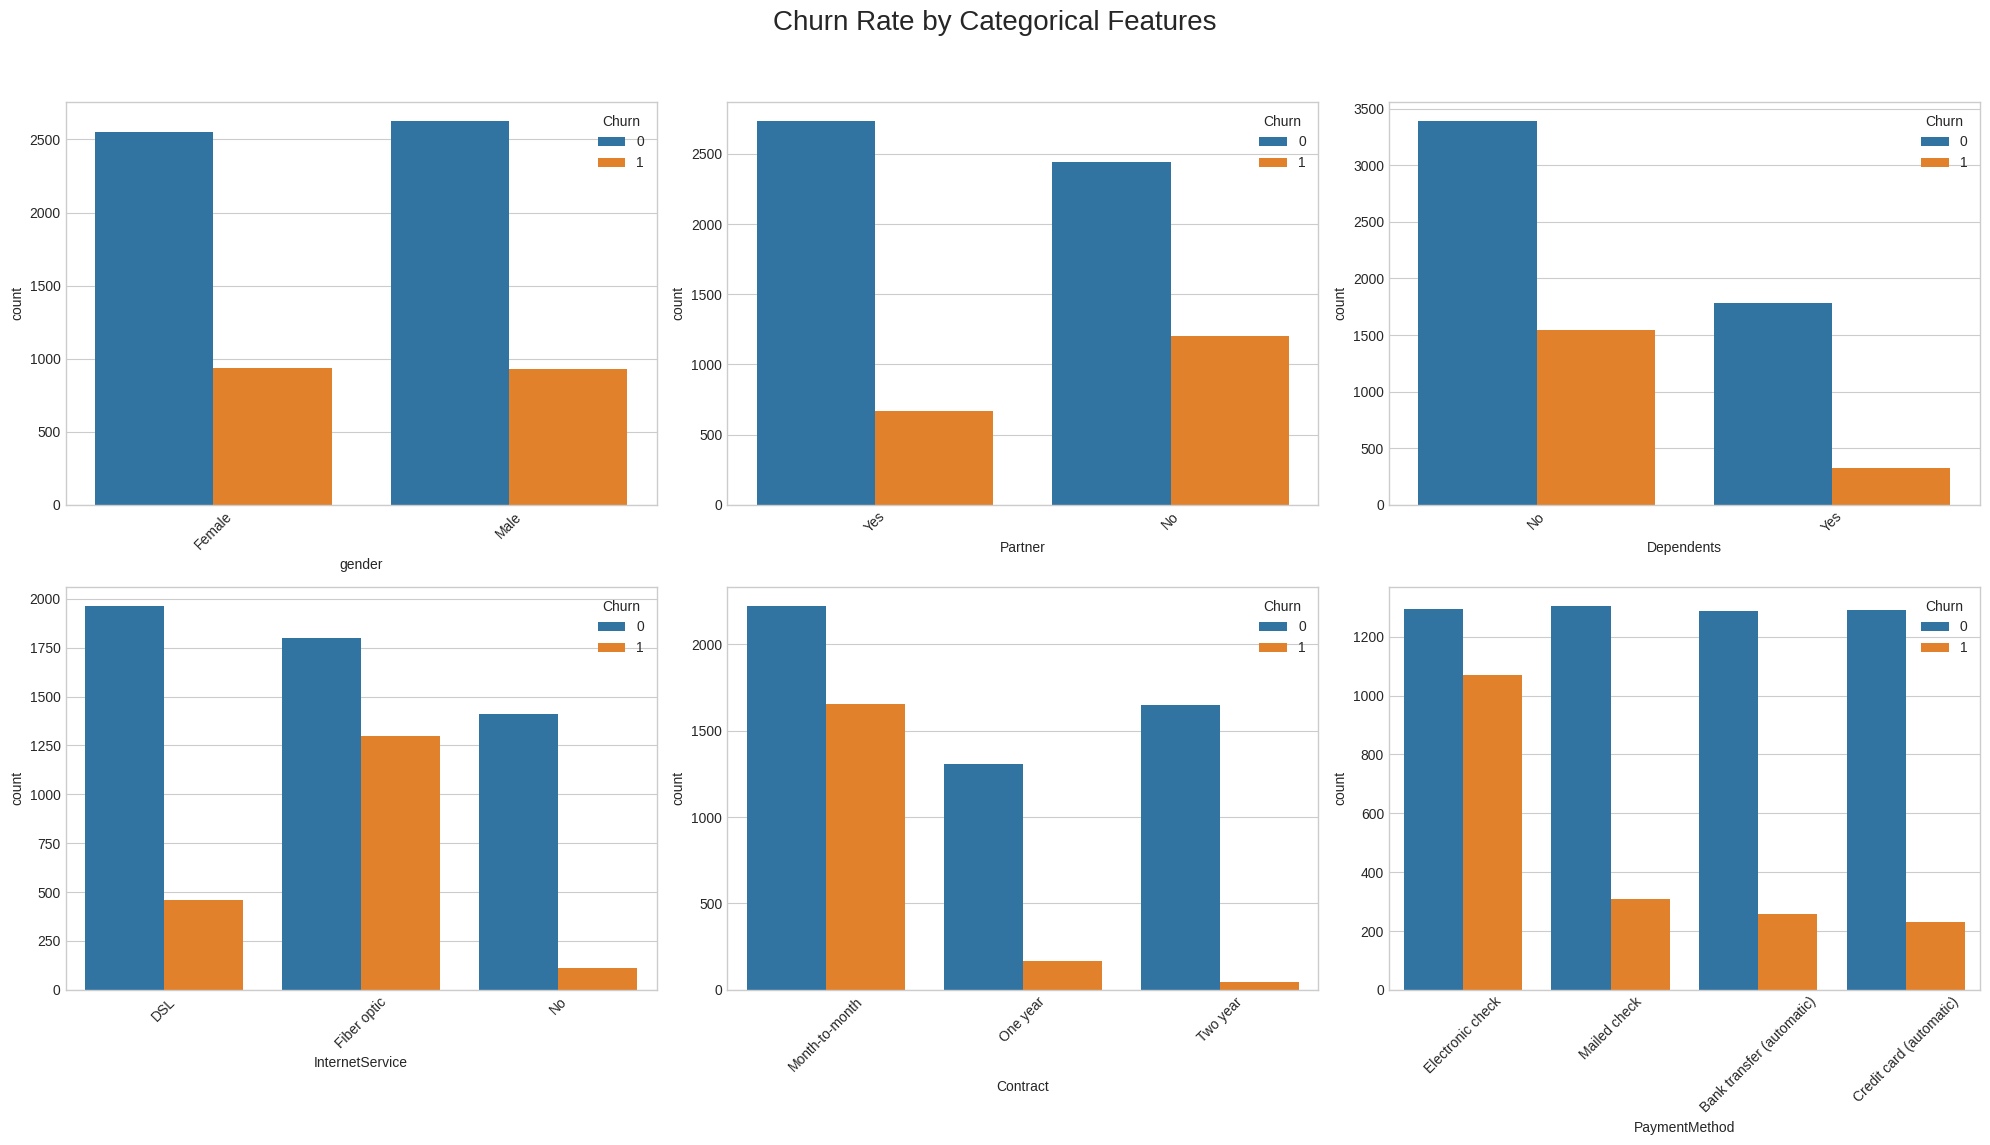

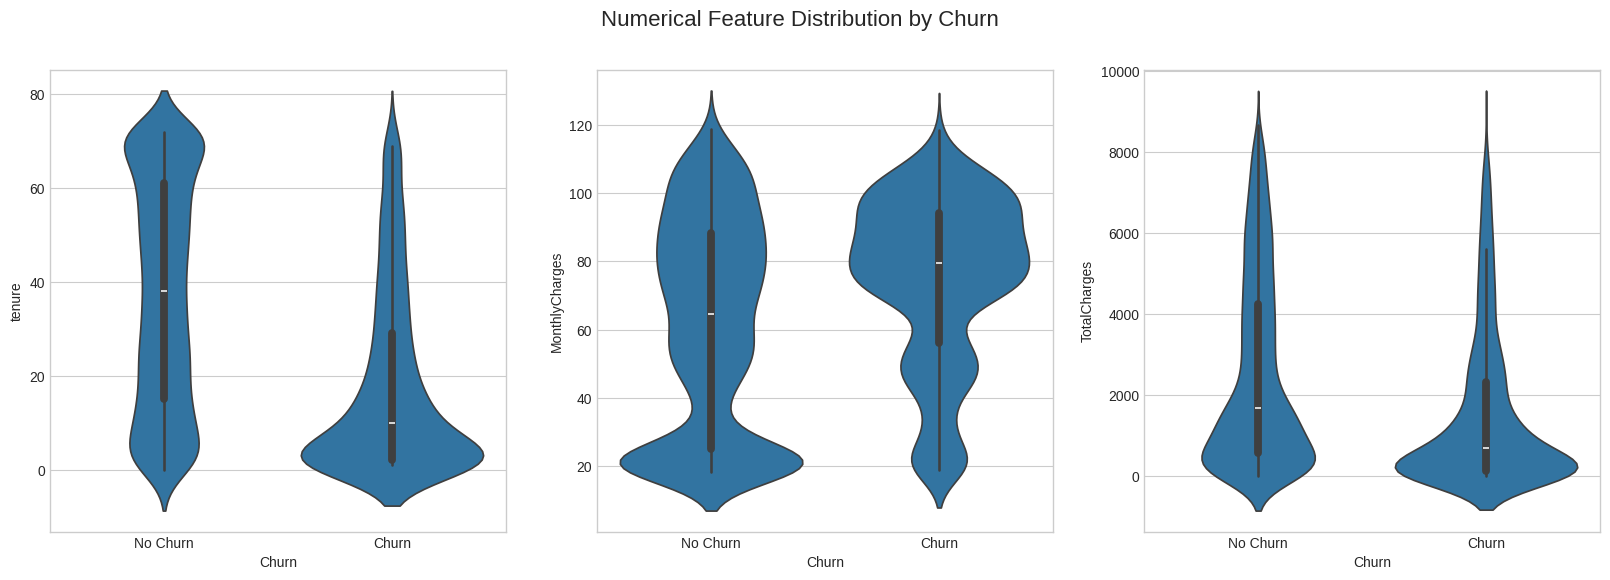

In [48]:
# ## 3. Exploratory Data Analysis (EDA)
if not df.empty:
    # 클래스 분포 확인
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='Churn', data=df)
    plt.title('Churn Distribution (0: No, 1: Yes)', fontsize=16)
    plt.xticks([0, 1], ['No Churn', 'Churn'])
    plt.show()

    # 주요 범주형 변수와 이탈율 관계 시각화
    categorical_features = ['gender', 'Partner', 'Dependents', 'InternetService', 'Contract', 'PaymentMethod']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Churn Rate by Categorical Features', fontsize=20)

    for i, feature in enumerate(categorical_features):
        row, col = i // 3, i % 3
        sns.countplot(x=feature, hue='Churn', data=df, ax=axes[row, col])
        axes[row, col].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 수치형 변수와 이탈 관계 시각화
    numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Numerical Feature Distribution by Churn', fontsize=16)

    for i, feature in enumerate(numerical_features):
        sns.violinplot(x='Churn', y=feature, data=df, ax=axes[i])
        axes[i].set_xticklabels(['No Churn', 'Churn'])

    plt.show()

In [49]:
# ## 4. Data Preprocessing for Modeling
if not df.empty:
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    # 수치형/범주형 변수 식별
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    # 전처리 파이프라인 생성
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")


Training data shape: (5634, 19)
Test data shape: (1409, 19)


In [50]:
# ## 5. Model Training and Comparison
if not df.empty:
    # 불균형 데이터 처리를 위한 가중치 계산
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

    models = {
        "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        "LightGBM": LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight, n_jobs=-1)
    }

    results = {}

    for name, model in models.items():
        print(f"\n--- Training {name} ---")

        # 모델과 전처리기를 파이프라인으로 결합
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])

        pipeline.fit(X_train, y_train)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        roc_auc = roc_auc_score(y_test, y_pred_proba)

        results[name] = {'ROC AUC': roc_auc}
        print(f"ROC AUC on test data: {roc_auc:.4f}")

    results_df = pd.DataFrame(results).T
    print("\n--- Model Performance Comparison ---")
    print(results_df.sort_values(by='ROC AUC', ascending=False))


--- Training Logistic Regression ---
ROC AUC on test data: 0.8416

--- Training Random Forest ---
ROC AUC on test data: 0.8194

--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
ROC AUC on test data: 0.8363

--- Model Performance Comparison ---
                      ROC AUC
Logistic Regression  0.841639
LightGBM             0.836286
Random Forest        0.819390



--- Hyperparameter Tuning for LightGBM ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 3756, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265442 -> initscore=-1.017873
[LightGBM] [Info] Start training from score -1.017873
[LightGBM] [Info] Number of positive: 997, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info

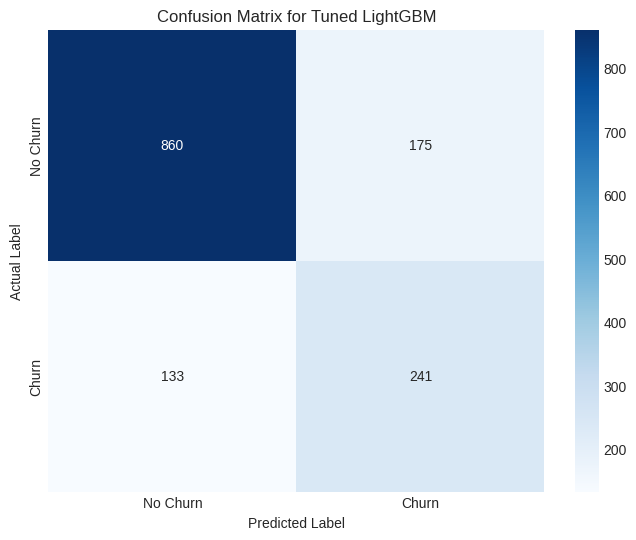


Classification Report
              precision    recall  f1-score   support

    No Churn       0.87      0.83      0.85      1035
       Churn       0.58      0.64      0.61       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.78      1409



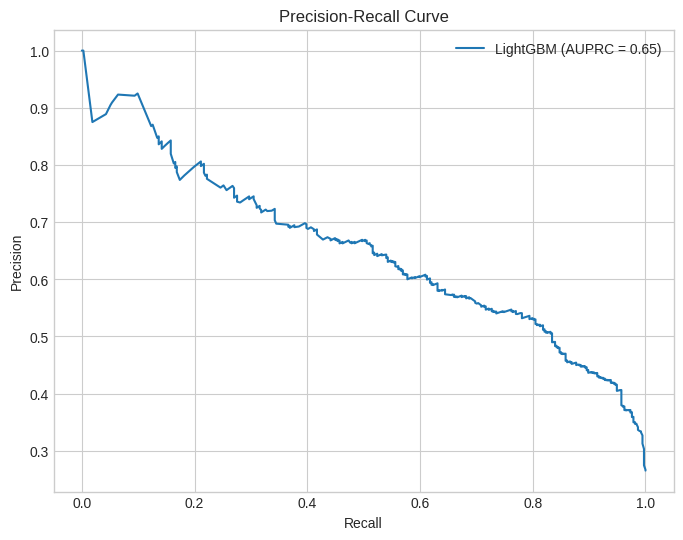

In [51]:
# ## 6. Hyperparameter Tuning and Final Analysis
if not df.empty:
    print(f"\n--- Hyperparameter Tuning for LightGBM ---")

    # LightGBM 파이프라인
    lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight, n_jobs=-1))])

    param_grid = {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 50, 70],
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=lgbm_pipeline, param_distributions=param_grid, n_iter=5,
        scoring='roc_auc', cv=skf, verbose=1, random_state=42
    )

    random_search.fit(X_train, y_train)
    print("\nBest parameters found: ", random_search.best_params_)
    best_model = random_search.best_estimator_

    # ### 최종 모델 상세 분석 ###
    y_pred_best_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred_best = best_model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title('Confusion Matrix for Tuned LightGBM')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print('\nClassification Report')
    print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_best_proba)
    auprc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'LightGBM (AUPRC = {auprc:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()